# **Wine Recommender System Modeling**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#wine = pd.read_csv('/content/gdrive/MyDrive/Drexel/winemag-data-130k-v2.csv')  #AS Path
wine = pd.read_csv('/content/gdrive/MyDrive/winemag-data-130k-v2.csv') #SN path

## *Data Cleaning and Preprocessing*

Dropping Irrelevant data

In [ ]:
#Drop duplicated reviews
wine = wine.drop_duplicates(subset=['taster_name', 'title'])

#Drop two irrelevant columns
wine = wine.drop(["Unnamed: 0", "taster_twitter_handle"], axis=1)

Point Range

In [ ]:
#Create point range feature
wine['point_range'] = np.where(wine['points'] > 88, "High", "Low")
wine.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery,point_range
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,Low
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,Low
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,Low
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,Low
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,Low


In [ ]:
#Check distribution to ensure that the target variable is balanced
wine.point_range.value_counts()

Low     62674
High    56297
Name: point_range, dtype: int64

Descriptions

In [ ]:
#Define stop words
exclusions = set(['a','about','above','after','again','against','all','also','am','an','and','any','are',"arent",'as','at',
'be','because','been','before','being','below','between','both','but','by',
'can',"cant",'cannot','com','could',"couldnt",'did',"didnt",'do','does',"doesnt",'doing',"dont",'down','during',
'each','else','ever','few','for','from','further','get',
'had',"hadnt",'has',"hasnt",'have',"havent",'having','he',"hed","hell","hes",'hence','her','here',"heres",'hers','herself','him','himself','his','how',"hows",'however','http',
'i',"id","ill","im","ive",'if','in','into','is',"isnt",'it','its','itself','just','k',"lets",'like',
'me','more','most',"mustnt",'my','myself','no','nor','not','now',
'of','off','on','once','only','or','other','otherwise','ought','our','ours','ourselves','out','over','own',
'r','same','shall',"shant",'she',"shed","shell","shes",'should',"shouldnt",'since','so','some','such',
'than','that',"thats",'the','their','theirs','them','themselves','then','there',"theres",'therefore','these','they',"theyd","theyll","theyre","theyve",'this','those','through','to','too',
'under','until','up','very',
'was',"wasnt",'we',"wed","well","were","weve","werent",'what',"whats",'when',"whens",'where',"wheres",'which','while','who',"whos",'whom','why',"whys",'with',"wont",'would',"wouldnt",'www',
'you',"youd","youll","youre","youve",'your','yours','yourself','yourselves'])

In [ ]:
#Create function to clean the description column for use in knowledge-based recommender

import string

def clean_description(x):
    if isinstance(x, str):
        x = x.lower()
        x = x.translate(str.maketrans('', '', string.punctuation))
        x = x.split()
        final_lst = []
        for word in x:
            if word not in exclusions:
                final_lst.append(word)
        return final_lst
    else:
        return []

In [ ]:
#clean the description of each wine to isolate every word
wine['description'] = wine['description'].apply(clean_description)

#check to see if description is cleaned as expected
wine[['description']].head()

,description
0,"[aromas, include, tropical, fruit, broom, brim..."
1,"[ripe, fruity, wine, smooth, still, structured..."
2,"[tart, snappy, flavors, lime, flesh, rind, dom..."
3,"[pineapple, rind, lemon, pith, orange, blossom..."
4,"[much, regular, bottling, 2012, comes, across,..."


Dropping Nulls

In [ ]:
# remove rows with price of null
wine = wine.dropna(subset=['price'])

#shape should now be 118971 - 8265 = 110706
wine.shape

(110706, 13)

In [ ]:
## remove rows with country of null
wine = wine.dropna(subset=['country'])

#shape should now be 110706 - 55 = 110651
wine.shape

(110651, 13)

In [ ]:
## remove rows with variety of null
wine = wine.dropna(subset=['variety'])

#shape should now be 110651 - 1 = 110650
wine.shape

(110650, 13)

Cleaning Location

In [ ]:
#Combine province and region_2 (for US states) to get location feature

#Create location column as duplicate of province to start
wine['location'] = wine.loc[:, 'province']

#For U.S states with region_2 we will assign this as the location
wine.loc[(wine['country']=='US') & (wine['region_2'].notnull()), 'location'] = wine['region_2']

Creat Price Buckets

In [ ]:
#Create buckets of wine prices to explore potential improvements of using categorical variable instead of numeric price
wine.loc[wine['price']<10, 'price_bucket']= '<10.00'
wine.loc[(wine['price']<20) & (wine['price'] >=10), 'price_bucket']= '10.00-19.99'
wine.loc[(wine['price']<30) & (wine['price'] >=20), 'price_bucket']= '20.00-29.99'
wine.loc[(wine['price']<40) & (wine['price'] >=30), 'price_bucket']= '30.00-39.99'
wine.loc[(wine['price']<50) & (wine['price'] >=40), 'price_bucket']= '40.00-49.99'
wine.loc[(wine['price']<60) & (wine['price'] >=50), 'price_bucket']= '50.00-59.99'
wine.loc[(wine['price']<80) & (wine['price'] >=60), 'price_bucket']= '60.00-79.99'
wine.loc[(wine['price']<100) & (wine['price'] >=80), 'price_bucket']= '80.0-99.99'
wine.loc[(wine['price']<200) & (wine['price'] >=100), 'price_bucket']= '100.00-199.99'
wine.loc[wine['price'] >=200, 'price_bucket']= '200.0+'

In [ ]:
wine.price_bucket.value_counts()

10.00-19.99      33432
20.00-29.99      26438
30.00-39.99      15692
40.00-49.99      11059
60.00-79.99       7607
50.00-59.99       6952
80.0-99.99        3052
100.00-199.99     2999
<10.00            2676
200.0+             743
Name: price_bucket, dtype: int64

Cleaning Price

In [ ]:
#Create log transformed price column to handle the right skew
wine['transformed_price'] = np.log(wine['price'])

Cleaning Points

In [ ]:
#Finally, re-scale the points column
wine['points_transformed'] = (wine['points'] - 80) * 0.5 + 1

In [ ]:
#View the final dataframe before one hot encoding
wine.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,variety,winery,point_range,location,price_bucket,transformed_price,points_transformed
1,Portugal,"[ripe, fruity, wine, smooth, still, structured...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,Low,Douro,10.00-19.99,2.708050,4.5
2,US,"[tart, snappy, flavors, lime, flesh, rind, dom...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,Low,Willamette Valley,10.00-19.99,2.639057,4.5
3,US,"[pineapple, rind, lemon, pith, orange, blossom...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,Low,Michigan,10.00-19.99,2.564949,4.5
4,US,"[much, regular, bottling, 2012, comes, across,...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,Low,Willamette Valley,60.00-79.99,4.174387,4.5
5,Spain,"[blackberry, raspberry, aromas, show, typical,...",Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,Low,Northern Spain,10.00-19.99,2.708050,4.5


In [ ]:
wine.shape

(110650, 17)

One-Hot Encoding - location

In [ ]:
wine.location.unique().size

437

In [ ]:
# One-Hot Encoding the location column
locations = pd.get_dummies(wine.location, prefix = 'Location')
locations.head()

,Location_Achaia,Location_Aconcagua Costa,Location_Aconcagua Valley,Location_Aegean,Location_Agioritikos,Location_Ahr,Location_Alenquer,Location_Alentejano,Location_Alentejo,Location_Alenteo,...,Location_Western Australia,Location_Western Cape,Location_Wiener Gemischter Satz,Location_Willamette Valley,Location_Württemberg,Location_Zenata,Location_Österreichischer Perlwein,Location_Österreichischer Sekt,Location_Štajerska,Location_Župa
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Append encoded locations to the modeling dataframe
wine2 = wine.join(locations)
wine2.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,...,Location_Western Australia,Location_Western Cape,Location_Wiener Gemischter Satz,Location_Willamette Valley,Location_Württemberg,Location_Zenata,Location_Österreichischer Perlwein,Location_Österreichischer Sekt,Location_Štajerska,Location_Župa
1,Portugal,"[ripe, fruity, wine, smooth, still, structured...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),...,0,0,0,0,0,0,0,0,0,0
2,US,"[tart, snappy, flavors, lime, flesh, rind, dom...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),...,0,0,0,1,0,0,0,0,0,0
3,US,"[pineapple, rind, lemon, pith, orange, blossom...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,...,0,0,0,0,0,0,0,0,0,0
4,US,"[much, regular, bottling, 2012, comes, across,...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,...,0,0,0,1,0,0,0,0,0,0
5,Spain,"[blackberry, raspberry, aromas, show, typical,...",Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,...,0,0,0,0,0,0,0,0,0,0


One-Hot Encoding - Variety

In [ ]:
wine.variety.unique().size

691

In [ ]:
# One-Hot Encoding the variety column
varieties = pd.get_dummies(wine.variety, prefix = 'Variety')
varieties.head()

,Variety_Abouriou,Variety_Agiorgitiko,Variety_Aglianico,Variety_Aidani,Variety_Airen,Variety_Albana,Variety_Albanello,Variety_Albariño,Variety_Albarossa,Variety_Aleatico,...,Variety_Xynisteri,Variety_Yapincak,Variety_Zibibbo,Variety_Zierfandler,Variety_Zierfandler-Rotgipfler,Variety_Zinfandel,Variety_Zlahtina,Variety_Zweigelt,Variety_Çalkarası,Variety_Žilavka
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Append encoded varieties to modeling dataframe
wine2 = wine2.join(varieties)
wine2.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,title,...,Variety_Xynisteri,Variety_Yapincak,Variety_Zibibbo,Variety_Zierfandler,Variety_Zierfandler-Rotgipfler,Variety_Zinfandel,Variety_Zlahtina,Variety_Zweigelt,Variety_Çalkarası,Variety_Žilavka
1,Portugal,"[ripe, fruity, wine, smooth, still, structured...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),...,0,0,0,0,0,0,0,0,0,0
2,US,"[tart, snappy, flavors, lime, flesh, rind, dom...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),...,0,0,0,0,0,0,0,0,0,0
3,US,"[pineapple, rind, lemon, pith, orange, blossom...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,...,0,0,0,0,0,0,0,0,0,0
4,US,"[much, regular, bottling, 2012, comes, across,...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,...,0,0,0,0,0,0,0,0,0,0
5,Spain,"[blackberry, raspberry, aromas, show, typical,...",Ars In Vitro,87,15.0,Northern Spain,Navarra,NaN,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,...,0,0,0,0,0,0,0,0,0,0


# *Modeling*

## Content-Based

In [ ]:
#View the unique reviewer names to select a user for content-based recommendations
wine2.taster_name.value_counts()

Roger Voss            18068
Michael Schachner     13762
Kerin O’Keefe          8852
Paul Gregutt           8825
Virginie Boone         8663
Matt Kettmann          5612
Joe Czerwinski         4630
Sean P. Sullivan       4410
Anna Lee C. Iijima     3969
Jim Gordon             3745
Anne Krebiehl MW       2993
Lauren Buzzeo          1581
Susan Kostrzewa        1003
Mike DeSimone           440
Jeff Jenssen            415
Alexander Peartree      381
Carrie Dykes            128
Fiona Adams              24
Christina Pickard         6
Name: taster_name, dtype: int64

In [ ]:
#select target user for which ratings will be predicted based on their preferences
content_df = wine2[wine2['taster_name']=='Roger Voss']

#filter the data frame to only consider wines that have multiple variety/location combinations
content_df = content_df.groupby(['variety', 'location']).filter(lambda x:len(x)>3)
content_df.shape

(17481, 1145)

## Regression (Content-Based)

In [ ]:
#Remove irrelevant columns which won't be used in modeling
regression_df = content_df.drop(['country', 'description', 'designation', 'points', 'price', 'province', 'region_1', 'region_2', 'variety',
                         'winery', 'point_range', 'location'], axis=1)

regression_df.shape

(17481, 1133)

In [ ]:
#Split the dataframe into X and y datasets
X = regression_df.drop(['taster_name', 'title', 'points_transformed'], axis=1)
y = regression_df['points_transformed']

In [ ]:
X.head()

,price_bucket,transformed_price,Location_Achaia,Location_Aconcagua Costa,Location_Aconcagua Valley,Location_Aegean,Location_Agioritikos,Location_Ahr,Location_Alenquer,Location_Alentejano,...,Variety_Xynisteri,Variety_Yapincak,Variety_Zibibbo,Variety_Zierfandler,Variety_Zierfandler-Rotgipfler,Variety_Zinfandel,Variety_Zlahtina,Variety_Zweigelt,Variety_Çalkarası,Variety_Žilavka
1,10.00-19.99,2.708050,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,20.00-29.99,3.178054,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,20.00-29.99,3.295837,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11,30.00-39.99,3.401197,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
42,<10.00,2.197225,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#One hot encode for price and add the columns to X dataset
prices = pd.get_dummies(X.price_bucket, prefix = 'Price')
X = X.join(prices)
X = X.drop(['price_bucket'], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1001)

#We will be comparing the metrics using the numeric price attribute versus the categorical price buckets
#Start by removing the price buckets and keep only numeric
X_train_num = X_train.drop(['Price_10.00-19.99', 'Price_100.00-199.99', 'Price_20.00-29.99', 'Price_30.00-39.99',
                        'Price_40.00-49.99', 'Price_50.00-59.99', 'Price_200.0+', 'Price_60.00-79.99', 'Price_80.0-99.99', 'Price_<10.00'], axis=1)
X_test_num = X_test.drop(['Price_10.00-19.99', 'Price_100.00-199.99', 'Price_20.00-29.99', 'Price_30.00-39.99',
                      'Price_40.00-49.99', 'Price_50.00-59.99', 'Price_200.0+', 'Price_60.00-79.99', 'Price_80.0-99.99', 'Price_<10.00'], axis=1)

#Create another x train and x test with the price buckets and remove numeric price
X_train_bucket = X_train.drop(['transformed_price'], axis=1)
X_test_bucket = X_test.drop(['transformed_price'], axis=1)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
#First try with numeric price

linreg = linear_model.LinearRegression()

linreg.fit(X_train_num, y_train)

lin_pred = linreg.predict(X_test_num)

rmse = mean_squared_error(y_test, lin_pred, squared=False)
print('RMSE:', rmse)

r2 = r2_score(y_test, lin_pred)
print('R-Squared:', r2)

RMSE: 1.0090695543126686
R-Squared: 0.5757512581515942


In [ ]:
#Now try with price buckets

linreg2 = linear_model.LinearRegression()

linreg2.fit(X_train_bucket, y_train)

lin_pred2 = linreg2.predict(X_test_bucket)

rmse_2 = mean_squared_error(y_test, lin_pred2, squared=False)
print('RMSE:', rmse_2)

r2_2 = r2_score(y_test, lin_pred2)
print('R-Squared:', r2_2)

RMSE: 1.0301843761406742
R-Squared: 0.5578106530632669


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
#Create parameter grid to be used for hyperparameter tuning
dtr_params = {'max_depth':[8, 16, 20, 28], 'min_samples_split':[25,75,100,150]}

#Hyperparemeter tuning using GridSearch CV
dtr_tuning = GridSearchCV(estimator = DecisionTreeRegressor(), param_grid = dtr_params, scoring='r2', cv=10)

dtr_tuning.fit(X_train_num,y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [8, 16, 20, 28],
                         'min_samples_split': [25, 75, 100, 150]},
             scoring='r2')

In [ ]:
#View best parameters
dtr_tuning.best_params_

{'max_depth': 28, 'min_samples_split': 150}

In [ ]:
#Fit decision tree classifier and make predictions using best parameters
dtr = DecisionTreeRegressor(max_depth=28, min_samples_split=150)
dtr.fit(X_train_num, y_train)

dtr_pred = dtr.predict(X_test_num)

In [ ]:
#View metrics to compare with other regression models
rmse = mean_squared_error(y_test, dtr_pred, squared=False)
print('RMSE:', rmse)

r2 = r2_score(y_test, dtr_pred)
print('R-Squared:', r2)

RMSE: 1.0079424556412064
R-Squared: 0.576698473615183


In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
#Create parameter grid for hyperparemeter tuning
rf_params = {'n_estimators':[75, 150, 200], 'max_depth':[15, 20, 25], 'min_samples_split':[50, 75, 150]}

#Use GridSearch CV to get best parameters
rf_tuning = GridSearchCV(estimator = RandomForestRegressor(), param_grid = rf_params, scoring='r2', cv=3)

rf_tuning.fit(X_train_num, y_train)

In [ ]:
#View best parameters
rf_tuning.best_params_

{'max_depth': 25, 'min_samples_split': 75, 'n_estimators': 200}

In [ ]:
#Fit random forest using best parameters and make predictions
rfr = RandomForestRegressor(n_estimators= 200, max_depth= 25, min_samples_split=75)
rfr.fit(X_train_num, y_train)

rfr_pred = rfr.predict(X_test_num)

RandomForestRegressor(max_depth=25, min_samples_split=75, n_estimators=200)

In [ ]:
#Compare random forest metrics with other regression models
rmse = mean_squared_error(y_test, rfr_pred, squared=False)
print('RMSE:', rmse)

r2 = r2_score(y_test, rfr_pred)
print('R-Squared:', r2)

RMSE: 0.9787786786297535
R-Squared: 0.6008396838457339


Random Forest Regressor has the best overall RMSE and R-Squared and would therefore be best to implement in the 'real world'

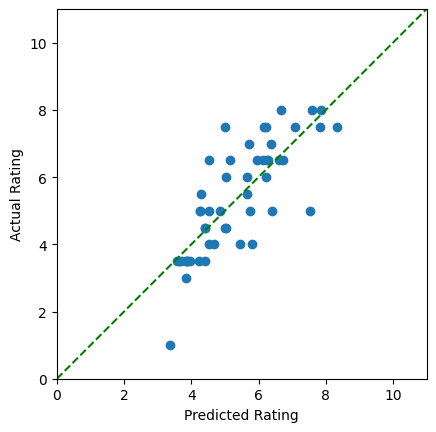

In [ ]:
#Visualize scatterplot of predicted ratings versus actual for random forest regressor
plt.scatter(rfr_pred[:50], y_test[:50])
plt.xlim(0, 11)
plt.ylim(0, 11)
ax = plt.gca()
ax.set_aspect('equal')
plt.ylabel('Actual Rating')
plt.xlabel('Predicted Rating')
x = np.linspace(0, 11)
plt.plot(x, x+0, '--g')
plt.show()

## Classification (Content-Based)

In [ ]:
clf_df = content_df.drop(['country', 'description', 'designation', 'points', 'price', 'province', 'region_1', 'region_2', 'variety',
                         'winery', 'points_transformed', 'location'], axis=1)

clf_df.shape

(17481, 1133)

In [ ]:
#Encode the categorical labels
clf_df.loc[clf_df['point_range']=='High', 'classifier']=1
clf_df.loc[clf_df['point_range']=='Low', 'classifier']=0

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
#Split the dataframe into X and y
X_logreg = clf_df.drop(['taster_name', 'title', 'point_range', 'classifier'], axis=1)
y_logreg = clf_df['classifier']

In [ ]:
#Add the one hot encoded price buckets to the X dataframe
X_logreg = X_logreg.join(prices)
X_logreg = X_logreg.drop(['price_bucket'], axis=1)

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_logreg, y_logreg, test_size=0.2, random_state=1001)

#We will be comparing the metrics using the numeric price attribute versus the categorical price buckets
#Start by removing the price buckets and keep only numeric
X_train2_num = X_train2.drop(['Price_10.00-19.99', 'Price_100.00-199.99', 'Price_20.00-29.99', 'Price_30.00-39.99',
                        'Price_40.00-49.99', 'Price_50.00-59.99', 'Price_200.0+', 'Price_60.00-79.99', 'Price_80.0-99.99', 'Price_<10.00'], axis=1)
X_test2_num = X_test2.drop(['Price_10.00-19.99', 'Price_100.00-199.99', 'Price_20.00-29.99', 'Price_30.00-39.99',
                      'Price_40.00-49.99', 'Price_50.00-59.99', 'Price_200.0+', 'Price_60.00-79.99', 'Price_80.0-99.99', 'Price_<10.00'], axis=1)

#Create another x train and x test with the price buckets and remove numeric price
X_train2_bucket = X_train2.drop(['transformed_price'], axis=1)
X_test2_bucket = X_test2.drop(['transformed_price'], axis=1)

In [ ]:
#We will start with logistic regression using the numeric price attribute
clf = LogisticRegression()

clf.fit(X_train2_num, y_train2)

clf_pred = clf.predict(X_test2_num)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

         0.0       0.79      0.83      0.81      1853
         1.0       0.79      0.75      0.77      1644

    accuracy                           0.79      3497
   macro avg       0.79      0.79      0.79      3497
weighted avg       0.79      0.79      0.79      3497



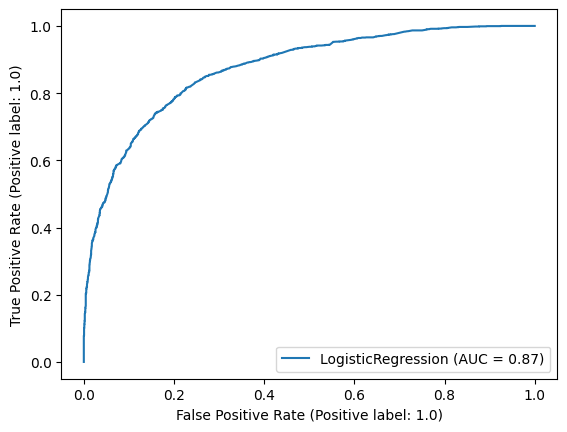

[[1535  318]
 [ 413 1231]]


In [ ]:
from sklearn import metrics

#Show the metrics for the model performance
print(metrics.classification_report(y_test2, clf_pred))

#Plot the ROC Curve
metrics.RocCurveDisplay.from_estimator(clf, X_test2_num, y_test2)
plt.show()

#Display the Confusion Matrix
confusion = metrics.confusion_matrix(y_test2, clf_pred)
print(confusion)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

         0.0       0.79      0.82      0.81      1853
         1.0       0.79      0.76      0.77      1644

    accuracy                           0.79      3497
   macro avg       0.79      0.79      0.79      3497
weighted avg       0.79      0.79      0.79      3497



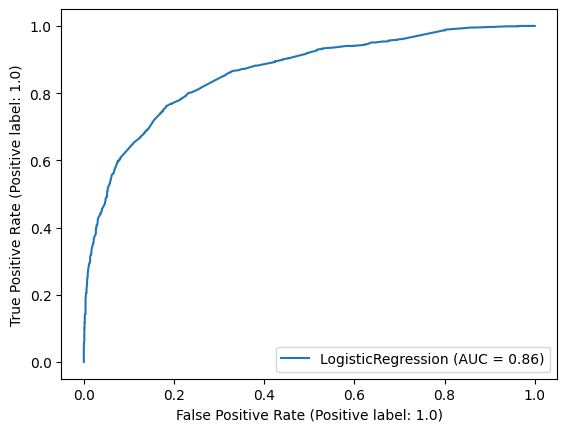

[[1513  340]
 [ 392 1252]]


In [ ]:
#Now try logistic regression using categorical, one-hot encoded price buckets
clf2 = LogisticRegression()

clf2.fit(X_train2_bucket, y_train2)

clf_pred2 = clf2.predict(X_test2_bucket)

#Show the metrics for the model performance
print(metrics.classification_report(y_test2, clf_pred2))

#Plot the ROC Curve
metrics.RocCurveDisplay.from_estimator(clf2, X_test2_bucket, y_test2)
plt.show()

#Display the Confusion Matrix
confusion = metrics.confusion_matrix(y_test2, clf_pred2)
print(confusion)

The numeric prices performed better overall than using one hot encoded price buckets

In [ ]:
from sklearn.tree import DecisionTreeClassifier

#Hyperparameter tuning for decision tree classifier
dtc_params = {'criterion':['gini', 'entropy'], 'max_depth':[20, 25, 30], 'min_samples_split':[75,150,200]}

dtc_tuning = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = dtc_params, scoring='roc_auc', cv=10)

dtc_tuning.fit(X_train2_num, y_train2)

In [ ]:
dtc_tuning.best_params_

{'criterion': 'gini', 'max_depth': 25, 'min_samples_split': 150}

              precision    recall  f1-score   support

         0.0       0.79      0.80      0.80      1853
         1.0       0.77      0.76      0.77      1644

    accuracy                           0.78      3497
   macro avg       0.78      0.78      0.78      3497
weighted avg       0.78      0.78      0.78      3497



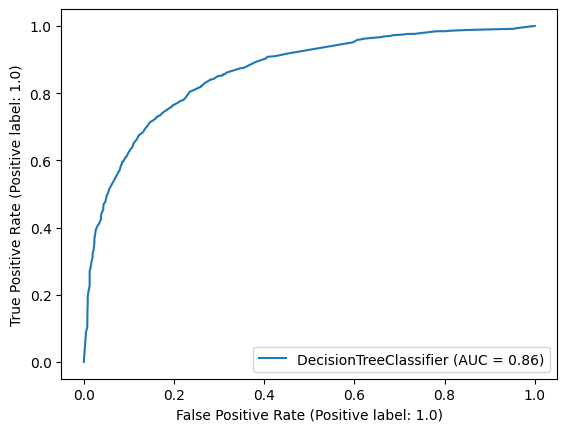

[[1490  363]
 [ 394 1250]]


In [ ]:
dtc = DecisionTreeClassifier(criterion='gini', max_depth=25, min_samples_split=150)

dtc.fit(X_train2_num, y_train2)

dtc_pred = dtc.predict(X_test2_num)

print(metrics.classification_report(y_test2, dtc_pred))

#Plot the ROC Curve
metrics.RocCurveDisplay.from_estimator(dtc, X_test2_num, y_test2)
plt.show()

#Display the Confusion Matrix
confusion = metrics.confusion_matrix(y_test2, dtc_pred)
print(confusion)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#hyperparameter tuning for random forest classifier
rfc_params = {'criterion': ['gini', 'entropy'], 'n_estimators':[10, 100, 200], 'max_depth':[10, 20, 25], 'min_samples_split':[75, 100, 150]}

rfc_tuning = GridSearchCV(estimator = RandomForestClassifier(), param_grid = rfc_params, scoring='roc_auc', cv=3)

rfc_tuning.fit(X_train2_num, y_train2)

In [ ]:
rfc_tuning.best_params_

{'criterion': 'entropy',
 'max_depth': 25,
 'min_samples_split': 75,
 'n_estimators': 200}

In [ ]:
rfc = RandomForestClassifier(criterion = 'entropy', n_estimators= 200, max_depth= 25, min_samples_split=75)
rfc.fit(X_train2_num, y_train2)

RandomForestClassifier(criterion='entropy', max_depth=25, min_samples_split=75,
                       n_estimators=200)

              precision    recall  f1-score   support

         0.0       0.79      0.81      0.80      1853
         1.0       0.78      0.76      0.77      1644

    accuracy                           0.79      3497
   macro avg       0.78      0.78      0.78      3497
weighted avg       0.79      0.79      0.79      3497



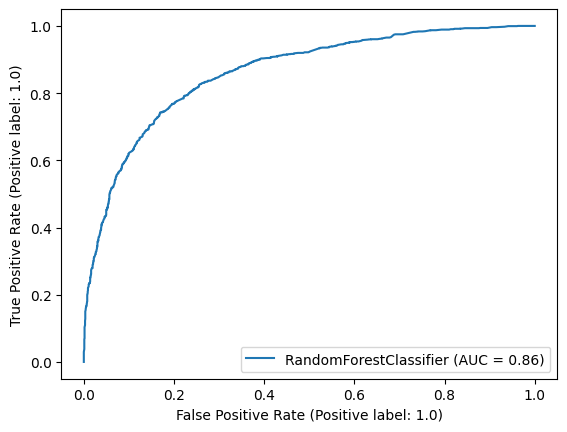

[[1502  351]
 [ 400 1244]]


In [ ]:
rfc_pred = rfc.predict(X_test2_num)

print(metrics.classification_report(y_test2, rfc_pred))

#Plot the ROC Curve
metrics.RocCurveDisplay.from_estimator(rfc, X_test2_num, y_test2)
plt.show()

#Display the Confusion Matrix
confusion = metrics.confusion_matrix(y_test2, rfc_pred)
print(confusion)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
k_range = list(range(1, 31))
knn_param_grid = dict(n_neighbors = k_range)

knn_tuning = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv = 10, scoring = 'accuracy', return_train_score = False, verbose = 1)

knn_tuning.fit(X_train2_num, y_train2)

In [ ]:
knn_tuning.best_params_

{'n_neighbors': 21}

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 21)
knn.fit(X_train2_num, y_train2)

KNeighborsClassifier(n_neighbors=21)

              precision    recall  f1-score   support

         0.0       0.80      0.78      0.79      1853
         1.0       0.76      0.78      0.77      1644

    accuracy                           0.78      3497
   macro avg       0.78      0.78      0.78      3497
weighted avg       0.78      0.78      0.78      3497



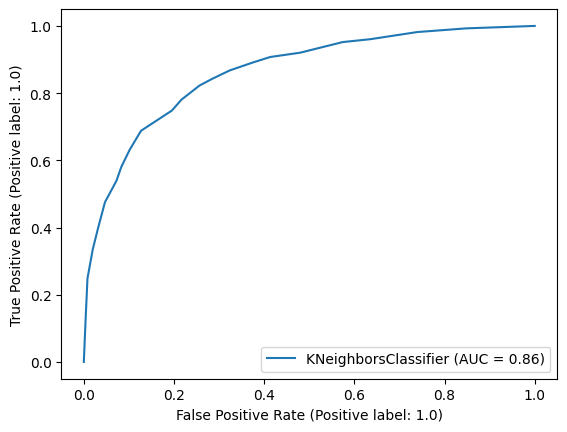

[[1452  401]
 [ 361 1283]]


In [ ]:
from sklearn import metrics

knn_pred = knn.predict(X_test2_num)

print(metrics.classification_report(y_test2, knn_pred))

#Plot the ROC Curve
metrics.RocCurveDisplay.from_estimator(knn, X_test2_num, y_test2)
plt.show()

#Display the Confusion Matrix
confusion = metrics.confusion_matrix(y_test2, knn_pred)
print(confusion)

# *Real-World Examples*

## Regression Example

In [ ]:
#in practice for Roger Voss
#train will be all of Roger's reviews
train = wine2[wine2['taster_name']=='Roger Voss']
#predictions need to be made for all un-reviewed wines in database
predict = wine2[wine2['taster_name']!='Roger Voss']

predict.shape

(92582, 1145)

In [ ]:
X_rv = train.drop(['taster_name', 'country', 'description', 'designation', 'points', 'price', 'province', 'region_1', 'region_2', 'variety',
                         'winery', 'point_range', 'location', 'title', 'points_transformed', 'price_bucket'], axis=1)
y_rv = train['points_transformed']

#create list of wines Roger has reviewed and then remove those wines from the prediction dataset
rv_wines = list(train.title.unique())
predict = predict[~predict.title.isin(rv_wines)]

predict.shape

(92552, 1145)

In [ ]:
X_pred = predict.drop(['taster_name', 'country', 'description', 'designation', 'points', 'price', 'province', 'region_1', 'region_2', 'variety',
                         'winery', 'point_range', 'location', 'title', 'points_transformed', 'price_bucket'], axis=1)

In [ ]:
#Fit random forest regressor (best performing model) with all of Roger's wine reviews
rfr2 = RandomForestRegressor(n_estimators= 200, max_depth= 25, min_samples_split=75)
rfr2.fit(X_rv, y_rv)

#Make predictions of all unreviewed wines and append predicted rating to the dataframe
rfr_pred2 = rfr2.predict(X_pred)
predict['pred_rating']=rfr_pred2
#Remove any predictions outside of our rating range
predict = predict[(predict['pred_rating']>=0) & (predict['pred_rating']<=11)]

recs = predict[['title', 'country', 'description', 'designation', 'price', 'province', 'region_1', 'winery', 'variety', 'pred_rating']]
recs = recs.sort_values(by=['pred_rating'], ascending=False)

In [ ]:
rv = train[['title', 'country', 'designation', 'price', 'province', 'region_1', 'region_2', 'winery', 'variety',
            'points_transformed']].sort_values(by=['points_transformed'], ascending=False)

#View the top 10 rated wines by Roger
rv[:10]

,title,country,designation,price,province,region_1,region_2,winery,variety,points_transformed
36528,Krug 2002 Brut (Champagne),France,Brut,259.0,Champagne,Champagne,NaN,Krug,Champagne Blend,11.0
111755,Château Cheval Blanc 2010 Saint-Émilion,France,NaN,1500.0,Bordeaux,Saint-Émilion,NaN,Château Cheval Blanc,Bordeaux-style Red Blend,11.0
89728,Louis Roederer 2008 Cristal Vintage Brut (Cha...,France,Cristal Vintage Brut,250.0,Champagne,Champagne,NaN,Louis Roederer,Champagne Blend,11.0
58352,Château Léoville Barton 2010 Saint-Julien,France,NaN,150.0,Bordeaux,Saint-Julien,NaN,Château Léoville Barton,Bordeaux-style Red Blend,11.0
111753,Château Lafite Rothschild 2010 Pauillac,France,NaN,1500.0,Bordeaux,Pauillac,NaN,Château Lafite Rothschild,Bordeaux-style Red Blend,11.0
89729,Salon 2006 Le Mesnil Blanc de Blancs Brut Char...,France,Le Mesnil Blanc de Blancs Brut,617.0,Champagne,Champagne,NaN,Salon,Chardonnay,11.0
42197,Casa Ferreirinha 2008 Barca-Velha Red (Douro),Portugal,Barca-Velha,450.0,Douro,NaN,NaN,Casa Ferreirinha,Portuguese Red,11.0
114972,Quinta do Noval 2011 Nacional Vintage (Port),Portugal,Nacional Vintage,650.0,Port,NaN,NaN,Quinta do Noval,Port,11.0
111756,Château Léoville Las Cases 2010 Saint-Julien,France,NaN,359.0,Bordeaux,Saint-Julien,NaN,Château Léoville Las Cases,Bordeaux-style Red Blend,11.0
114973,Taylor Fladgate 2011 Vargellas Vinhas Velhas V...,Portugal,Vargellas Vinhas Velhas Vintage,268.0,Port,NaN,NaN,Taylor Fladgate,Port,10.5


In [ ]:
#View the top 10 recommended wines by the random forest regressor
recs[:10]

,title,country,description,designation,price,province,region_1,winery,variety,pred_rating
120391,Blair 2013 Roger Rose Vineyard Chardonnay (Arr...,US,"[nose, singlevineyard, wine, strong, often, ov...",Roger Rose Vineyard,2013.0,California,Arroyo Seco,Blair,Chardonnay,9.164200
89478,Emmerich Knoll 2013 Ried Loibenberg Smaragd Gr...,Austria,"[wet, earth, rainwet, stones, damp, moss, wild...",Ried Loibenberg Smaragd,1100.0,Wachau,NaN,Emmerich Knoll,Grüner Veltliner,9.065178
88870,Biondi Santi 2006 Riserva (Brunello di Montal...,Italy,"[biondisanti, performs, exceptionally, elegant...",Riserva,900.0,Tuscany,Brunello di Montalcino,Biondi Santi,Sangiovese Grosso,9.042355
77028,Penfolds 2008 Grange Shiraz (South Australia),Australia,"[size, weight, come, expect, australias, famou...",Grange,850.0,South Australia,South Australia,Penfolds,Shiraz,9.031522
56953,Penfolds 2010 Grange Shiraz (South Australia),Australia,"[inky, embryonic, wine, deserves, cellared, le...",Grange,850.0,South Australia,South Australia,Penfolds,Shiraz,9.031522
108484,Biondi Santi 2007 Riserva (Brunello di Montal...,Italy,"[thanks, highest, vineyards, montalcino, biond...",Riserva,800.0,Tuscany,Brunello di Montalcino,Biondi Santi,Sangiovese,9.013349
56959,Henschke 2010 Hill of Grace Shiraz (Eden Valley),Australia,"[yin, granges, yang, wines, completely, differ...",Hill of Grace,820.0,South Australia,Eden Valley,Henschke,Shiraz,9.013349
117844,Masseto 2011 Merlot (Toscana),Italy,"[rich, ripe, expression, one, italys, iconic, ...",NaN,625.0,Tuscany,Toscana,Masseto,Merlot,8.984004
38978,Yao Ming 2010 Family Reserve Cabernet Sauvigno...,US,"[debate, pricing, yao, mings, new, reserve, un...",Family Reserve,625.0,California,Napa Valley,Yao Ming,Cabernet Sauvignon,8.984004
25382,Yao Ming 2011 Family Reserve Cabernet Sauvigno...,US,"[imposing, athlete, impressive, wine, getgo, h...",Family Reserve,625.0,California,Napa Valley,Yao Ming,Cabernet Sauvignon,8.984004


In [ ]:
recs.shape

(92552, 10)

## Classification Example

In [ ]:
#Label encode for the target variable and split the data the same way that was done above for regression
wine2.loc[wine2['point_range']=='High', 'classifier']=1
wine2.loc[wine2['point_range']=='Low', 'classifier']=0

train2 = wine2[wine2['taster_name']=='Roger Voss']
predict2 = wine2[wine2['taster_name']!='Roger Voss']

X_rv2 = train2.drop(['taster_name', 'country', 'description', 'designation', 'points', 'price', 'province', 'region_1', 'region_2', 'variety',
                         'winery', 'point_range', 'location', 'title', 'points_transformed', 'classifier', 'price_bucket'], axis=1)

y_rv2 = train2['classifier']

predict2 = predict2[~predict2.title.isin(rv_wines)]

In [ ]:
X_pred2 = predict2.drop(['taster_name', 'country', 'description', 'designation', 'points', 'price', 'province', 'region_1', 'region_2', 'variety',
                         'winery', 'point_range', 'location', 'title', 'points_transformed', 'classifier', 'price_bucket'], axis=1)

In [ ]:
#Recommend yes/no using logistic regression
logreg2 = LogisticRegression()
logreg2.fit(X_rv2, y_rv2)

logreg_pred2 = logreg2.predict(X_pred2)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
#Create column to indicate whether or not wine should be recommended
predict2['Recommend?']=logreg_pred2

#Remove all wines with a '0' which indicates 'do not recommend'
predict2 = predict2[predict2['Recommend?']==1]

In [ ]:
recs2 = predict2[['title', 'country', 'description', 'designation', 'price', 'province', 'region_1', 'winery', 'variety', 'points_transformed']]
recs2 = recs2.sort_values(by=['points_transformed'], ascending=False)

#View top 10 recommended wines ranked by other user rating
recs2[:10]

,title,country,description,designation,price,province,region_1,winery,variety,points_transformed
118058,Verité 2007 La Muse Red (Sonoma County),US,"[wine, dazzles, perfection, sourced, vineyards...",La Muse,450.0,California,Sonoma County,Verité,Bordeaux-style Red Blend,11.0
7335,Avignonesi 1995 Occhio di Pernice (Vin Santo ...,Italy,"[thick, molasses, dark, caramelized, brown, su...",Occhio di Pernice,210.0,Tuscany,Vin Santo di Montepulciano,Avignonesi,Prugnolo Gentile,11.0
45781,Biondi Santi 2010 Riserva (Brunello di Montal...,Italy,"[gorgeous, fragrant, wine, opens, classic, san...",Riserva,550.0,Tuscany,Brunello di Montalcino,Biondi Santi,Sangiovese,11.0
123545,Cayuse 2008 Bionic Frog Syrah (Walla Walla Val...,US,"[initially, rather, subdued, frog, tamed, sudd...",Bionic Frog,80.0,Washington,Walla Walla Valley (WA),Cayuse,Syrah,11.0
113929,Charles Smith 2006 Royal City Syrah (Columbia ...,US,"[2005, charles, smith, introduced, three, high...",Royal City,80.0,Washington,Columbia Valley (WA),Charles Smith,Syrah,11.0
111754,Casanova di Neri 2007 Cerretalto (Brunello di...,Italy,"[takes, moments, appreciate, enormity, intensi...",Cerretalto,270.0,Tuscany,Brunello di Montalcino,Casanova di Neri,Sangiovese Grosso,11.0
45798,Cardinale 2006 Cabernet Sauvignon (Napa Valley),US,"[tasted, flight, great, famous, napa, wines, c...",NaN,200.0,California,Napa Valley,Cardinale,Cabernet Sauvignon,11.0
345,Chambers Rosewood Vineyards NV Rare Muscat (Ru...,Australia,"[wine, contains, material, 100, years, old, sh...",Rare,350.0,Victoria,Rutherglen,Chambers Rosewood Vineyards,Muscat,11.0
39286,Tenuta dell'Ornellaia 2007 Masseto Merlot (Tos...,Italy,"[perfect, wine, classic, vintage, 2007, masset...",Masseto,460.0,Tuscany,Toscana,Tenuta dell'Ornellaia,Merlot,11.0
1557,Williams Selyem 2009 Precious Mountain Vineyar...,US,"[stupendous, pinot, noir, showing, beautifully...",Precious Mountain Vineyard,94.0,California,Sonoma Coast,Williams Selyem,Pinot Noir,10.5


In [ ]:
recs2.shape

(54101, 10)

## **Constraint-Based**

In [ ]:
wine.shape

(110650, 17)

In [ ]:
#Create average user rating column to be used to rank wines in constraint-based system
wine3 = wine.set_index(['title'])
wine3['avg_rating'] = wine3.groupby('title')['points'].mean()

wine3.head()

In [ ]:
def constraint_based(df):

    #get the input country
    print("Input preferred country (United States = 'US'):")
    country = input().lower()

    #get the target low price
    print("Input lowest preferred bottle price (in dollars):")
    low_price = float(input())

    #get the maximum wine price
    print("Input highest preferred bottle price (in dollars):")
    high_price = float(input())

    #get the preferred variety
    print("Input preferred wine variety (e.g. 'Pinot Noir'):")
    variety = input().lower()

    #get the preferred keyword
    print("Input relevant preferred keyword associated with other wine reviews (e.g. 'fruity'):")
    keyword = input().lower()
    keyword_mask = df['description'].apply(lambda x: True if keyword in x else False)

    #create copy of dataframe to find the related wines based on the search queries
    wines = df.copy()

    wines['country'] = wines['country'].str.lower()
    wines['variety'] = wines['variety'].str.lower()

    #filter new dataframe based on user search queries
    wines = wines[(wines['country'] == country) &
                    (wines['price'] >= low_price) &
                    (wines['price'] <= high_price) &
                    (wines['variety'].str.contains(variety)) &
                    keyword_mask]

    if len(wines) > 0:

        #Return search results based on average rating
        if len(wines) <= 10:
          return wines.sort_values('avg_rating', ascending=False)

        else:
          return wines.sort_values('avg_rating', ascending=False)[:10]

    else:
        print("Your search criteria returned zero results")

In [ ]:
#Test constraint based system using criteria France, 10, 100, Bordeaux, Red
constraint_based(wine3)

Input preferred country (United States = 'US'):
france
Input lowest preferred bottle price (in dollars):
10
Input highest preferred bottle price (in dollars):
100
Input preferred wine variety (e.g. 'Pinot Noir'):
bordeaux
Input relevant preferred keyword associated with other wine reviews (e.g. 'fruity'):
red


,country,description,designation,points,price,province,region_1,region_2,taster_name,variety,winery,point_range,location,price_bucket,transformed_price,points_transformed,avg_rating
title,,,,,,,,,,,,,,,,,
Château Clos Haut-Peyraguey 2013 Sauternes,france,"[often, case, poor, red, wine, vintage, bordea...",NaN,95,45.0,Bordeaux,Sauternes,NaN,Roger Voss,bordeaux-style white blend,Château Clos Haut-Peyraguey,High,Bordeaux,40.00-49.99,3.806662,8.5,95.0
Château Tronquoy-Lalande 2009 Saint-Estèphe,france,"[tannins, fine, rich, fruitcake, smoky, flavor...",NaN,94,45.0,Bordeaux,Saint-Estèphe,NaN,Roger Voss,bordeaux-style red blend,Château Tronquoy-Lalande,High,Bordeaux,40.00-49.99,3.806662,8.0,94.0
Château Calon 2011 Saint-Émilion,france,"[firm, structured, depth, plus, spice, wood, a...",NaN,94,65.0,Bordeaux,Saint-Émilion,NaN,Roger Voss,bordeaux-style red blend,Château Calon,High,Bordeaux,60.00-79.99,4.174387,8.0,94.0
Château Talbot 2001 Saint-Julien,france,"[great, link, tannins, delicious, red, berry, ...",NaN,94,54.0,Bordeaux,Saint-Julien,NaN,Roger Voss,bordeaux-style red blend,Château Talbot,High,Bordeaux,50.00-59.99,3.988984,8.0,94.0
Château Gruaud Larose 2001 Saint-Julien,france,"[perfumed, elegant, structured, wine, elements...",NaN,94,48.0,Bordeaux,Saint-Julien,NaN,Roger Voss,bordeaux-style red blend,Château Gruaud Larose,High,Bordeaux,40.00-49.99,3.871201,8.0,94.0
Château Clerc Milon 2011 Pauillac,france,"[continuing, impressive, development, clerc, m...",NaN,94,62.0,Bordeaux,Pauillac,NaN,Roger Voss,bordeaux-style red blend,Château Clerc Milon,High,Bordeaux,60.00-79.99,4.127134,8.0,94.0
Château Grand Mayne 2009 Saint-Émilion,france,"[ripe, wine, open, smooth, tannins, dark, frui...",NaN,94,50.0,Bordeaux,Saint-Émilion,NaN,Roger Voss,bordeaux-style red blend,Château Grand Mayne,High,Bordeaux,50.00-59.99,3.912023,8.0,94.0
Château La Lagune 2004 Haut-Médoc,france,"[freshness, 2004, hallmark, deliciously, ripe,...",NaN,93,45.0,Bordeaux,Haut-Médoc,NaN,Roger Voss,bordeaux-style red blend,Château La Lagune,High,Bordeaux,40.00-49.99,3.806662,7.5,93.0
Château Latour-Martillac 2014 Pessac-Léognan,france,"[tightly, structured, dense, wine, packed, dry...",NaN,93,30.0,Bordeaux,Pessac-Léognan,NaN,Roger Voss,bordeaux-style red blend,Château Latour-Martillac,High,Bordeaux,30.00-39.99,3.401197,7.5,93.0


In [ ]:
#constraint based with recommended values instead of average rating
def constraint_based2(df):

    #get the input country
    print("Input preferred country (United States = 'US'):")
    country = input().lower()

    #get the target low price
    print("Input lowest preferred bottle price (in dollars):")
    low_price = float(input())

    #get the maximum wine price
    print("Input highest preferred bottle price (in dollars):")
    high_price = float(input())

    #get the preferred variety
    print("Input preferred wine variety (e.g. 'Pinot Noir'):")
    variety = input().lower()

    #get the preferred keyword
    print("Input relevant preferred keyword associated with other wine reviews (e.g. 'fruity'):")
    keyword = input().lower()
    keyword_mask = df['description'].apply(lambda x: True if keyword in x else False)

    #create copy of dataframe to find the related wines based on the search queries
    wines = df.copy()

    wines['country'] = wines['country'].str.lower()
    wines['variety'] = wines['variety'].str.lower()

    #filter new dataframe based on user search queries
    wines = wines[(wines['country'] == country) &
                    (wines['price'] >= low_price) &
                    (wines['price'] <= high_price) &
                    (wines['variety'].str.contains(variety)) &
                    keyword_mask]

    if len(wines) > 0:

        #Return search results based on average rating
        if len(wines) <= 10:
          return wines.sort_values('pred_rating', ascending=False)

        else:
          return wines.sort_values('pred_rating', ascending=False)[:10]

    else:
        print("Your search criteria returned zero results")

In [ ]:
#Run the constraint based system using recommended values from regression modeling for Roger Voss
#Criteria - Italy, 100, 1000, Sangiovese, Elegant
constraint_based2(recs)

Input preferred country (United States = 'US'):
italy
Input lowest preferred bottle price (in dollars):
100
Input highest preferred bottle price (in dollars):
1000
Input preferred wine variety (e.g. 'Pinot Noir'):
sangiovese
Input relevant preferred keyword associated with other wine reviews (e.g. 'fruity'):
elegant


,title,country,description,designation,price,province,region_1,winery,variety,pred_rating
45781,Biondi Santi 2010 Riserva (Brunello di Montal...,italy,"[gorgeous, fragrant, wine, opens, classic, san...",Riserva,550.0,Tuscany,Brunello di Montalcino,Biondi Santi,sangiovese,8.938307
88870,Biondi Santi 2006 Riserva (Brunello di Montal...,italy,"[biondisanti, performs, exceptionally, elegant...",Riserva,900.0,Tuscany,Brunello di Montalcino,Biondi Santi,sangiovese grosso,8.938307
71661,Poggio di Sotto 2007 Riserva (Brunello di Mon...,italy,"[poggio, di, sotto, steadily, worked, years, p...",Riserva,259.0,Tuscany,Brunello di Montalcino,Poggio di Sotto,sangiovese grosso,8.305065
21090,Biondi Santi 2008 Brunello di Montalcino,italy,"[grandson, inventor, brunello, iconic, bottlin...",NaN,200.0,Tuscany,Brunello di Montalcino,Biondi Santi,sangiovese,8.305065
111754,Casanova di Neri 2007 Cerretalto (Brunello di...,italy,"[takes, moments, appreciate, enormity, intensi...",Cerretalto,270.0,Tuscany,Brunello di Montalcino,Casanova di Neri,sangiovese grosso,8.305065
5491,Tenute Silvio Nardi 2007 Poggio Doria (Brunel...,italy,"[structured, elegant, opens, fruit, fragrance,...",Poggio Doria,148.0,Tuscany,Brunello di Montalcino,Tenute Silvio Nardi,sangiovese,7.607226
45797,Canalicchio di Sopra 2010 Riserva (Brunello d...,italy,"[underbrush, truffle, pressed, violet, tilled,...",Riserva,130.0,Tuscany,Brunello di Montalcino,Canalicchio di Sopra,sangiovese,7.607226
29375,Volpaia 2010 Il Puro Gran Selezione (Chianti ...,italy,"[structured, elegant, opens, aromas, blue, flo...",Il Puro Gran Selezione,150.0,Tuscany,Chianti Classico,Volpaia,sangiovese,7.607226
58774,Poggio di Sotto 2011 Rosso di Montalcino,italy,"[elegant, rosso, opens, intense, alluring, fra...",NaN,110.0,Tuscany,Rosso di Montalcino,Poggio di Sotto,sangiovese,7.607226
45796,Padelletti 2010 Riserva (Brunello di Montalcino),italy,"[forest, floor, darkskinned, berry, leather, t...",Riserva,115.0,Tuscany,Brunello di Montalcino,Padelletti,sangiovese,7.607226


In [ ]:
#Create average rating column for classification recommendations
recs2 = recs2.set_index(['title'])
recs2['avg_rating'] = recs2.groupby('title')['points_transformed'].mean()

recs2 = recs2.drop(['points_transformed'], axis=1)

In [ ]:
#Run final constraint based recommender for the classification recommendation data frame
#Criteria - US, 20, 50, Cabernet, Rich
constraint_based(recs2)

Input preferred country (United States = 'US'):
us
Input lowest preferred bottle price (in dollars):
20
Input highest preferred bottle price (in dollars):
50
Input preferred wine variety (e.g. 'Pinot Noir'):
cabernet
Input relevant preferred keyword associated with other wine reviews (e.g. 'fruity'):
rich


,country,description,designation,price,province,region_1,winery,variety,avg_rating
title,,,,,,,,,
Conn Creek 2007 Stagecoach Vineyard Cabernet Sauvignon (Atlas Peak),us,"[tremendous, cabernet, showing, authority, vin...",Stagecoach Vineyard,45.0,California,Atlas Peak,Conn Creek,cabernet sauvignon,9.0
Foxen 7200 2012 7200 Grassini Family Vineyard Cabernet Sauvignon (Happy Canyon of Santa Barbara),us,"[amazing, aromas, cherry, cedar, cocoa, powder...",7200 Grassini Family Vineyard,44.0,California,Happy Canyon of Santa Barbara,Foxen 7200,cabernet sauvignon,8.5
Sbragia 2006 Monte Rosso Vineyard Cabernet Sauvignon (Sonoma Valley),us,"[one, cellar, vibrantly, rich, forward, blackb...",Monte Rosso Vineyard,50.0,California,Sonoma Valley,Sbragia,cabernet sauvignon,8.5
Abeja 2009 Cabernet Sauvignon (Columbia Valley (WA)),us,"[good, enough, reserve, includes, 4, merlot, r...",NaN,44.0,Washington,Columbia Valley (WA),Abeja,cabernet sauvignon,8.5
Vinifera 2006 Cabernet Sauvignon (Napa Valley),us,"[young, vital, impressive, 100, cabernet, dry,...",NaN,40.0,California,Napa Valley,Vinifera,cabernet sauvignon,8.5
Laura Zahtila 2007 Barlow Vineyards Cabernet Sauvignon (Calistoga),us,"[dark, rich, dramatic, massively, constructed,...",Barlow Vineyards,50.0,California,Calistoga,Laura Zahtila,cabernet sauvignon,8.0
Sineann 2012 Cabernet Sauvignon (Columbia Valley (WA)),us,"[rich, ripe, concentrated, lush, array, black,...",NaN,30.0,Washington,Columbia Valley (WA),Sineann,cabernet sauvignon,8.0
Mattucci 2013 Bentley Ironworks Cabernet Sauvignon (Paso Robles),us,"[much, happening, nose, palate, bottling, hold...",Bentley Ironworks,45.0,California,Paso Robles,Mattucci,cabernet sauvignon,8.0
JD 2007 Cabernet Sauvignon (Diamond Mountain District),us,"[beautiful, ultrafine, cabernet, shows, rich, ...",NaN,40.0,California,Diamond Mountain District,JD,cabernet sauvignon,8.0


## *Cosine Similarity*

In [ ]:
from sklearn import preprocessing
from scipy.spatial.distance import cosine

In [ ]:
def cosine_sims(df, user, wine_title, neighbors):

    #Filter dataframe for only wines rated by the targer user
    user_df = df[df['taster_name']==user]

    #Prepare Price for modeling
    price_encoder = preprocessing.OneHotEncoder(sparse=False)
    wine_price = price_encoder.fit_transform(user_df[['price_bucket']])
    user_df['price_vector'] = wine_price.tolist()

    #Prepare Variety for modeling
    variety_encoder = preprocessing.OneHotEncoder(sparse=False)
    wine_variety = variety_encoder.fit_transform(user_df[['variety']])
    user_df['variety_vector'] = wine_variety.tolist()

    #Prepare Country for modeling
    country_encoder = preprocessing.OneHotEncoder(sparse=False)
    wine_country = country_encoder.fit_transform(user_df[['country']])
    user_df['country_vector'] = wine_country.tolist()

    #Prepare Province for modeling
    province_encoder = preprocessing.OneHotEncoder(sparse=False)
    wine_province = province_encoder.fit_transform(user_df[['province']])
    user_df['province_vector'] = wine_province.tolist()

    #Distance caluclation between two wines
    def distance_calculator(x, y):

        distance = 0
        mask1 = (user_df['title'] == x)
        mask2 = (user_df['title'] == y)

        distance += cosine(user_df[mask1]['price_vector'].tolist()[0], user_df[mask2]['price_vector'].tolist()[0])
        distance += cosine(user_df[mask1]['variety_vector'].tolist()[0], user_df[mask2]['variety_vector'].tolist()[0])
        distance += cosine(user_df[mask1]['country_vector'].tolist()[0], user_df[mask2]['country_vector'].tolist()[0])
        distance += cosine(user_df[mask1]['province_vector'].tolist()[0], user_df[mask2]['province_vector'].tolist()[0])

        return distance

    distances = []

    #Calculate distance between target wine and all other wines rated by the user
    for wine in user_df['title']:
        if wine != wine_title:
            distance = distance_calculator(wine_title, wine)
            comb = [(wine_title, wine), distance]
            distances.append(comb)


    #For the prediction, we will only use the rating from the closest specified neighbor wines
    cosine_sims.neighbors = sorted(distances, key=lambda x:x[1])[:neighbors]

    rating_calculator = 0

    #Retrieve the rating for each of the neighbor wines
    for neighbor in cosine_sims.neighbors:
        wine_title = neighbor[0][1]
        rating = user_df.loc[user_df['title']==wine_title]['points_transformed'].tolist()[0]
        rating_calculator += rating

    #Return the average rating of the five neighbor wines
    return rating_calculator/neighbors

In [ ]:
#Create a dataframe with only reviews from user Susan Kostrzewa
user_df = wine.loc[wine['taster_name']=='Susan Kostrzewa']

#Randomly select 50 wines to make predictions
random.seed(123)
test_wines = sorted(random.choices(user_df['title'].values.tolist(), k=50))

In [ ]:
#View the selected test wines
test_wines

['Alpha Estate 2016 Turtles Vineyard Malagousia (Florina)',
 'Autumn Hill 2007 Vintners Reserve Chardonnay (Monticello)',
 'Boutari 2010 Moschofilero (Mantinia)',
 'Bradgate 2007 Cabernet Sauvignon-Merlot-Shiraz Red (Stellenbosch)',
 'Capaia 2007 Blue Grove Hill Sauvignon Blanc (Philadelphia)',
 'Chrisohoou 2010 Xinomavro (Naoussa)',
 'Château Musar 2007 Cuvée Blanc White (Bekaa Valley)',
 'Domaine Sigalas 2014 Kavalieros Single Vineyard Assyrtiko (Santorini)',
 'Estate Biblia Chora 2007 Ovilos Red (Pangeon)',
 'Estate Biblia Chora 2015 White (Pangeon)',
 'Estate Constantin Gofas 2011 Mythic River Sauvignon-Roditis White (Corinth)',
 'Gerovassiliou 2007 Evangelo Red (Epanomi)',
 'Gerovassiliou 2007 Fumé Sauvignon Blanc (Epanomi)',
 'Greek Wine Cellars 2015 Assyrtiko (Santorini)',
 'Hatzi Michalis 2008 Veriki White (Atalanti Valley)',
 'KWV 2004 Shiraz (Western Cape)',
 'Keuka Spring 2007 Reserve Cabernet Sauvignon (Finger Lakes)',
 'Koenig Vineyards 2004 Cuvée Alden Private Reserve Red

In [ ]:
#Add the actual ratings to the list of test wines
actual_ratings = []
for wines in test_wines:
    rating = user_df.loc[user_df['title']==wines].points_transformed.values.tolist()[0]
    actual_ratings.append([wines, rating])

actual_ratings

[['Alpha Estate 2016 Turtles Vineyard Malagousia (Florina)', 4.5],
 ['Autumn Hill 2007 Vintners Reserve Chardonnay (Monticello)', 3.5],
 ['Boutari 2010 Moschofilero (Mantinia)', 3.5],
 ['Bradgate 2007 Cabernet Sauvignon-Merlot-Shiraz Red (Stellenbosch)', 5.0],
 ['Capaia 2007 Blue Grove Hill Sauvignon Blanc (Philadelphia)', 4.5],
 ['Chrisohoou 2010 Xinomavro (Naoussa)', 5.5],
 ['Château Musar 2007 Cuvée Blanc White (Bekaa Valley)', 2.5],
 ['Domaine Sigalas 2014 Kavalieros Single Vineyard Assyrtiko (Santorini)',
  7.5],
 ['Estate Biblia Chora 2007 Ovilos Red (Pangeon)', 6.0],
 ['Estate Biblia Chora 2015 White (Pangeon)', 4.0],
 ['Estate Constantin Gofas 2011 Mythic River Sauvignon-Roditis White (Corinth)',
  4.5],
 ['Gerovassiliou 2007 Evangelo Red (Epanomi)', 5.0],
 ['Gerovassiliou 2007 Fumé Sauvignon Blanc (Epanomi)', 5.5],
 ['Greek Wine Cellars 2015 Assyrtiko (Santorini)', 4.5],
 ['Hatzi Michalis 2008 Veriki White (Atalanti Valley)', 4.5],
 ['KWV 2004 Shiraz (Western Cape)', 2.5],
 ['

In [ ]:
y_pred_cosine = []

#Make predictions for all of the test wines using cosine similarity method
for wines in test_wines:
    predictions = cosine_sims(wine, 'Susan Kostrzewa', wines, 10)
    y_pred_cosine.append([wines, predictions])

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-65-6479043a9527>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_df['price_vector'] = wine_price.tolist()
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-65-6479043a9527>:14: SettingWithCopyWarning: 
A value is trying to be set 

In [ ]:
#View the cosine similarity predictions
y_pred_cosine

[['Alpha Estate 2016 Turtles Vineyard Malagousia (Florina)', 4.9],
 ['Autumn Hill 2007 Vintners Reserve Chardonnay (Monticello)', 2.8],
 ['Boutari 2010 Moschofilero (Mantinia)', 5.1],
 ['Bradgate 2007 Cabernet Sauvignon-Merlot-Shiraz Red (Stellenbosch)', 5.0],
 ['Capaia 2007 Blue Grove Hill Sauvignon Blanc (Philadelphia)', 4.45],
 ['Chrisohoou 2010 Xinomavro (Naoussa)', 4.55],
 ['Château Musar 2007 Cuvée Blanc White (Bekaa Valley)', 3.95],
 ['Domaine Sigalas 2014 Kavalieros Single Vineyard Assyrtiko (Santorini)',
  4.85],
 ['Estate Biblia Chora 2007 Ovilos Red (Pangeon)', 5.05],
 ['Estate Biblia Chora 2015 White (Pangeon)', 4.7],
 ['Estate Constantin Gofas 2011 Mythic River Sauvignon-Roditis White (Corinth)',
  4.35],
 ['Gerovassiliou 2007 Evangelo Red (Epanomi)', 4.65],
 ['Gerovassiliou 2007 Fumé Sauvignon Blanc (Epanomi)', 4.55],
 ['Greek Wine Cellars 2015 Assyrtiko (Santorini)', 5.0],
 ['Hatzi Michalis 2008 Veriki White (Atalanti Valley)', 4.55],
 ['KWV 2004 Shiraz (Western Cape)', 

In [ ]:
from sklearn.metrics import mean_squared_error as mse

In [ ]:
#Calculate RMSE for the cosine similarity predictions
mse([x[1] for x in actual_ratings], [x[1] for x in y_pred_cosine], squared=False)

0.9030503861911583

In [ ]:
actual = [x[1] for x in actual_ratings]
predicted = [x[1] for x in y_pred_cosine]

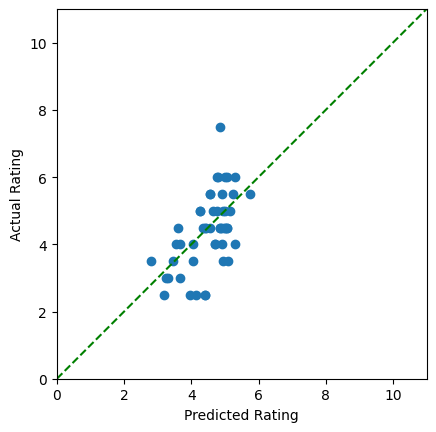

In [ ]:
#Visualize the cosine similarity predictions compared to the actual user ratings
plt.scatter(predicted, actual)
plt.xlim(0, 11)
plt.ylim(0, 11)
ax = plt.gca()
ax.set_aspect('equal')
plt.ylabel('Actual Rating')
plt.xlabel('Predicted Rating')
x = np.linspace(0, 11)
plt.plot(x, x+0, '--g')
plt.show()

In [ ]:
#Create example to show how single cosine similarity prediction was made
cos_example = cosine_sims(wine, 'Susan Kostrzewa', 'Bradgate 2007 Cabernet Sauvignon-Merlot-Shiraz Red (Stellenbosch)', 10)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-116-6479043a9527>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_df['price_vector'] = wine_price.tolist()
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-116-6479043a9527>:14: SettingWithCopyWarning: 
A value is trying to be se

In [ ]:
#Look at characteristics of the target wine
wine[(wine['taster_name']=='Susan Kostrzewa') & (wine['title']=='Bradgate 2007 Cabernet Sauvignon-Merlot-Shiraz Red (Stellenbosch)')][['title', 'country', 'province', 'variety', 'price_bucket', 'points_transformed']]

,title,country,province,variety,price_bucket,points_transformed
62559,Bradgate 2007 Cabernet Sauvignon-Merlot-Shiraz...,South Africa,Stellenbosch,Red Blend,10.00-19.99,5.0


In [ ]:
#Look at the characterstics of the 10 wines used to make predictions for the target wine
wine[(wine['taster_name']=='Susan Kostrzewa') & (wine['title'].isin([x[0][1]
for x in cosine_sims.neighbors]))][['title', 'country', 'province', 'variety', 'price_bucket', 'points_transformed']]

,title,country,province,variety,price_bucket,points_transformed
1255,Guardian Peak 2007 Merlot (Stellenbosch),South Africa,Stellenbosch,Merlot,10.00-19.99,5.0
4657,Backsberg 2003 Babylons Toren Red (Paarl),South Africa,Paarl,Red Blend,10.00-19.99,5.5
6778,Spier 2005 Pinotage (Stellenbosch),South Africa,Stellenbosch,Pinotage,10.00-19.99,5.5
10502,Spier 2006 Chenin Blanc (Stellenbosch),South Africa,Stellenbosch,Chenin Blanc,10.00-19.99,5.0
10507,Black Pearl 2005 Oro Red (Paarl),South Africa,Paarl,Red Blend,10.00-19.99,4.5
19201,Simonsig 2007 Sunbird Sauvignon Blanc (Stellen...,South Africa,Stellenbosch,Sauvignon Blanc,10.00-19.99,4.0
23859,Neil Ellis 2007 The Left Bank Red (Western Cape),South Africa,Western Cape,Red Blend,10.00-19.99,6.0
25223,Jardin 2007 Barrel Fermented Chardonnay (Stell...,South Africa,Stellenbosch,Chardonnay,10.00-19.99,5.0
28083,Rust en Vrede 2004 Estate Red (Stellenbosch),South Africa,Stellenbosch,Red Blend,40.00-49.99,5.0
32955,Beau Joubert 2006 Cabernet Sauvignon (Stellenb...,South Africa,Stellenbosch,Cabernet Sauvignon,10.00-19.99,4.5


In [ ]:
#Extract the neighbor ratings
neighbor_rates = wine[(wine['taster_name']=='Susan Kostrzewa') & (wine['title'].isin([x[0][1] for x in cosine_sims.neighbors]))]['points_transformed']

(array([0., 0., 0., 0., 1., 0., 2., 0., 4., 0., 2., 0., 1., 0., 0., 0.]),
 array([3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  , 5.25, 5.5 ,
        5.75, 6.  , 6.25, 6.5 , 6.75, 7.  ]),
 <BarContainer object of 16 artists>)

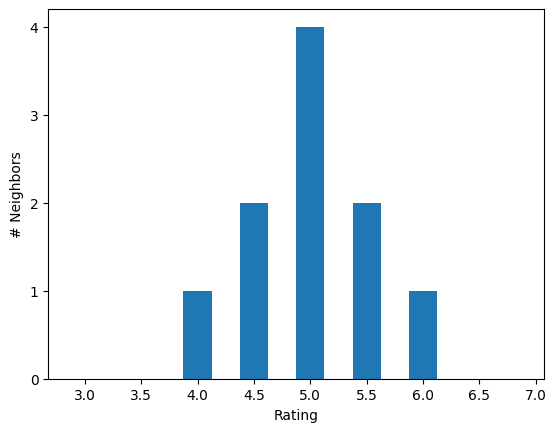

In [ ]:
#Visualize histogram of neighbor ratings
plt.xlabel('Rating')
plt.ylabel('# Neighbors')
plt.yticks(np.arange(0, 5, step=1))
plt.xticks(np.arange(0, 10, step=0.5))
plt.hist(neighbor_rates, range=(3, 7), bins=16, align='left')

## *Case-Based Recommender*

In [ ]:
def case_based(df, wine_title):

    #Prepare Price for modeling
    price_encoder = preprocessing.OneHotEncoder(sparse=False)
    wine_price = price_encoder.fit_transform(df[['price_bucket']])
    df['price_vector'] = wine_price.tolist()

    #Prepare Variety for modeling
    variety_encoder = preprocessing.OneHotEncoder(sparse=False)
    wine_variety = variety_encoder.fit_transform(df[['variety']])
    df['variety_vector'] = wine_variety.tolist()

    #Prepare Country for modeling
    country_encoder = preprocessing.OneHotEncoder(sparse=False)
    wine_country = country_encoder.fit_transform(df[['country']])
    df['country_vector'] = wine_country.tolist()

    #Prepare Province for modeling
    province_encoder = preprocessing.OneHotEncoder(sparse=False)
    wine_province = province_encoder.fit_transform(df[['province']])
    df['province_vector'] = wine_province.tolist()

    #Distance caluclation between two wines
    def distance_calculator(x, y):

        distance = 0
        mask1 = (df['title'] == x)
        mask2 = (df['title'] == y)

        distance += cosine(df[mask1]['price_vector'].tolist()[0], df[mask2]['price_vector'].tolist()[0])
        distance += cosine(df[mask1]['variety_vector'].tolist()[0], df[mask2]['variety_vector'].tolist()[0])
        distance += cosine(df[mask1]['country_vector'].tolist()[0], df[mask2]['country_vector'].tolist()[0])
        distance += cosine(df[mask1]['province_vector'].tolist()[0], df[mask2]['province_vector'].tolist()[0])

        return distance

    distances = []

    #Calculate distance between target wine and all other wines rated by the user
    for wine in df['title']:
        if wine != wine_title:
            distance = distance_calculator(wine_title, wine)
            comb = [(wine_title, wine), distance]
            distances.append(comb)


    distances = sorted(distances, key=lambda x:x[1])[:10]

    neighbor_list = []
    for entry in distances:
        neighbor_list.append(entry[0][1])

    df = df[df.title.isin(neighbor_list)]

    return df

In [ ]:
#Initial dataframe is too large to make case-based predictions for over 100k wines
#We will filter for only a single user to make the predictions more manageable
gordon = wine[wine.taster_name == 'Jim Gordon']

In [ ]:
#Make case-based predictions for wine
case_example = case_based(gordon, 'Las Positas 2014 Verdigris White (California)')

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-117-f1fbca7cafc4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price_vector'] = wine_price.tolist()
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
<ipython-input-117-f1fbca7cafc4>:11: SettingWithCopyWarning: 
A value is trying to be set on 

In [ ]:
#Visualize target wine characteristics
wine[wine['title']=='Las Positas 2014 Verdigris White (California)'][['title', 'country', 'province', 'variety', 'price_bucket']]

,title,country,province,variety,price_bucket
424,Las Positas 2014 Verdigris White (California),US,California,White Blend,30.00-39.99


In [ ]:
#Visualize neighbor wines identified by system
wine[wine['title'].isin(case_example.title)][['title', 'country', 'province', 'variety', 'price_bucket']]

,title,country,province,variety,price_bucket
5038,Elyse 2012 L'Ingenue Naggiar Vineyard White (S...,US,California,White Blend,30.00-39.99
9442,Elyse 2013 L'Ingenue White (Sierra Foothills),US,California,White Blend,30.00-39.99
19148,Alder Springs 2013 Apex 39 White (Mendocino),US,California,White Blend,30.00-39.99
27235,Sol Rouge 2014 Gypsy Blanc White (Lake County),US,California,White Blend,30.00-39.99
29541,Las Positas 2015 Verdigris White (Livermore Va...,US,California,White Blend,30.00-39.99
52861,Cobden Wini 2015 Clondaire Vineyards White (Ca...,US,California,White Blend,30.00-39.99
56250,Monochrome 2016 Variations on a Theme White (C...,US,California,White Blend,30.00-39.99
66153,Blindfold 2014 White (California),US,California,White Blend,30.00-39.99
81936,Monochrome 2016 Analog In A Digital Age White ...,US,California,White Blend,30.00-39.99
123729,Andis 2016 Cuvée Blanc White (Amador County),US,California,White Blend,30.00-39.99
